In [1]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import email
import email.policy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ham_filenames = [name for name in sorted(os.listdir(r'D:\Program Files\New folder\hamnspam\ham')) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(r'D:\Program Files\New folder\hamnspam\spam')) if len(name) > 20]

In [3]:
def load_email(is_spam, filename):
    directory = r'D:\Program Files\New folder\hamnspam\spam' if is_spam else r'D:\Program Files\New folder\hamnspam\ham'
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

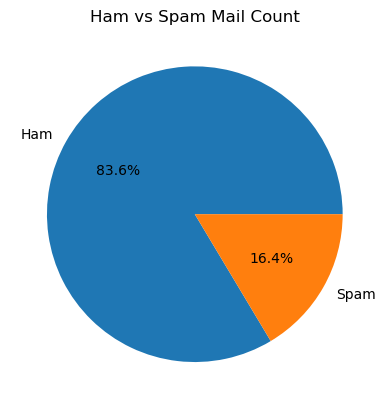

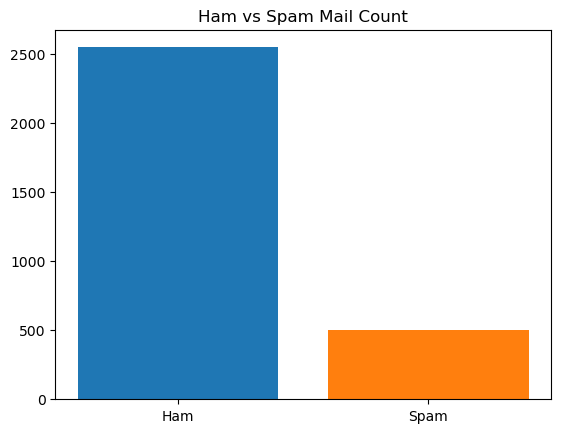

In [4]:
classes = ['Ham', 'Spam']
x = [len(ham_filenames), len(spam_filenames)]

plt.title('Ham vs Spam Mail Count')
plt.pie(x, labels=classes, autopct='%1.1f%%')

plt.savefig("pie_chart")
plt.show()

plt.title('Ham vs Spam Mail Count')
plt.bar(classes, x, color = ['#1f77b4', '#ff7f0e'])
plt.show()

## Tokenising Mails

In [5]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import string
import re

In [6]:
stop_words = (stopwords.words('english'))
punc = list(string.punctuation)

stop_words += punc
stop_words += ['-', 'http', 'yahoo', 'google', '_']

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

In [8]:
def simple_pos_tag(tag):
    if(tag.startswith('J')):
        return wordnet.ADJ
    elif(tag.startswith('V')):
        return wordnet.VERB
    elif(tag.startswith('N')):
        return wordnet.NOUN
    elif(tag.startswith('R')):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
def tokenise(words):
    clean_words = []
    word = word_tokenize(words.lower())
    
    for s in word:
        if len(s) <=2 or s in stop_words or not(s.isalpha()):
            continue
        clean_words.append(s)

    l_words = [lemmatizer.lemmatize(w, simple_pos_tag(w)) for w in clean_words]
    return l_words

In [10]:
def html_to_plain(mail):
    mail = mail.get_content()
    return BeautifulSoup(mail, 'html.parser').text.replace('\n\n', '')

In [11]:
def email_to_plain(email):
    mail_content_type = email.get_content_type()
    content = ''

    if mail_content_type == 'text/plain':
        content = (email.get_content().replace('-', ''))
    elif mail_content_type == 'text/html':
        content = (html_to_plain(email).replace('-', ''))
    
    content = re.sub(r'http\S+', '', content)
    return tokenise(content)

In [12]:
all_mails = []

In [13]:
for mail in ham_emails:
    all_mails.append((email_to_plain(mail), 'ham'))

In [14]:
for mail in spam_emails:
    try:
        mail.get_content()
    except LookupError:
        continue
    all_mails.append((email_to_plain(mail), 'spam'))

In [15]:
random.shuffle(all_mails)

## Visulising Data

In [16]:
all_words = []
for doc, cat in all_mails:
    all_words += doc

In [17]:
dict_words = {}
for w in all_words:
    if w in dict_words:
        dict_words[w] +=1
    else:
        dict_words[w] = 1
        
sorted_dict = sorted(dict_words.items(), key=lambda x:x[1], reverse=True)
print(len(sorted_dict))

24553


In [18]:
x = np.arange(1, len(sorted_dict)+1)
x_ = (np.ones(len(sorted_dict)))*3000
y = []
for i in range(len(sorted_dict)):
    y.append(sorted_dict[i][1])

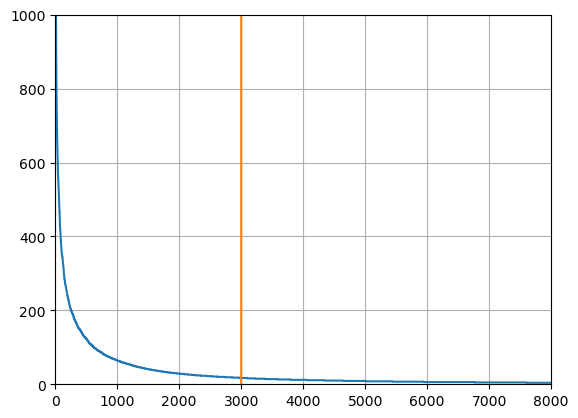

In [19]:
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.plot(x_,x)
plt.axis([0,8000,0,1000])
plt.grid(visible = True)
plt.show()

# Model Creation

## Train & Test Split

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X = [" ".join(doc) for doc, catagory in all_mails]

y = [catagory for doc, catagory in all_mails]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
len(X_train), len(X_test)

(2213, 738)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(max_features = 3000)

In [25]:
X_train_set = count_vec.fit_transform(X_train)
X_test_set = count_vec.transform(X_test)

In [26]:
matrix = X_train_set.todense()

In [27]:
count_vec.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 3000,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

### Naive Bayes

In [28]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [29]:
classifier = BernoulliNB()

classifier.fit(X_train_set, y_train)

BernoulliNB()

In [30]:
print("Training Score: ", classifier.score(X_train_set, y_train))
print("Testing Score: ", classifier.score(X_test_set, y_test))

Training Score:  0.9435155896972436
Testing Score:  0.9227642276422764


In [31]:
y_pred = classifier.predict(X_test_set)

con_mat = confusion_matrix(y_test, y_pred)
con_mat

array([[610,  26],
       [ 31,  71]], dtype=int64)

<Axes: >

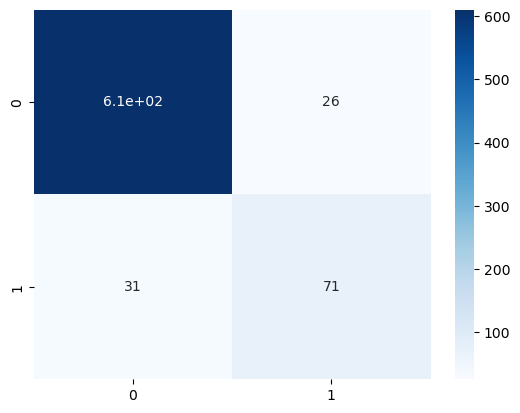

In [32]:
sns.heatmap(con_mat, cmap='Blues', annot=True)

In [33]:
import pickle
pickle.dump(classifier, open('model.pkl','wb')) 
pickle.dump(count_vec, open('count_vectorizer.pkl','wb'))


In [34]:
# Loading Saved Model
model = pickle.load(open('model.pkl', 'rb'))
count_vec = pickle.load(open('count_vectorizer.pkl', 'rb'))

In [35]:
#TEST ON A RANDOM MAIL

mail1 = ["We want to hear from you! Microsoft is committed to listening and acting on the feedback we receive from you. We would be grateful if you could spare 5-minutes to tell us about your experience with Microsoft.  Start Survey hank you for your time! The survey will close on April 21, 2023. Sincerely, Mala Anand Corporate Vice President, Customer Experience & Success Microsoft Corporation If the link above does not work, please copy and paste the following URL into your browser: https://experience.microsoft.com/isa/OMKYDYEMGTADPRLKHDOBBMHOLAPQOTAI/ms/hostpagefy23h2.html?__sid__=tpQE4VsvCSnl34COqhJQyUY3SOJALNcBrK_di88Lf5mHCATmcxlcYT0_TBu6IghKERTWtHyamZJWqQ8WEYbo_Q2&l=9 Microsoft has sponsored KS&R, an independent market research company, to conduct the Customer and Partner Experience survey. If you have any questions or issues reach out to KS&R at surveyfeedback@ksrsurvey.com. To learn more about the Customer and Partner Experience survey, please visit https://www.microsoft.com/cpefeedback. Your survey responses may be combined in accordance with Microsoft's Privacy Statement. You can adjust your data privacy settings by clicking the Data Disclosure link once you begin the survey."]
mail2 = ['Hello there, On account of Mahavir Jayanti, markets will be closed this Tuesday, 4th April 🔔 Trading will resume on Wednesday, 5th April MCX will also be  losed on 4th April for the morning session. The second session (5 PM - 11:30 PM) will take place as usual. All fund withdrawal requests placed on 4th April, will be processed on 5th April. The credit bill amount for equity, F&O or MCX segments on 3rd April will not be available for trading or withdrawal purposes until 4th April 2023 Post Mahavir Jayanti, you’ll be able to invest/trade as usual on your Upstox app. Happy Investing, Team Upstox']
type(mail)
mail = count_vec.transform(mail1)
# print(mail)
print(model.predict(mail))

['spam']
